# Reddit 게시물들 삭제에 대한 탐색적 데이터 분석

## Objectives
- 평소보다 게시물의 삭제건이 비정상적으로 급증하였다.
- 게시물들에 대한 삭제가 늘어난 이유에 대해서 탐색적 데이터 분석을 통하여 원인을 알아보고자 한다.
- 게시물들이 삭제되는 원인에 대한 분석을 통하여 해결방안에 대한 인사이트를 도출하고자 한다.

## Hypo & Main metrics
- 삭제된 게시물들은 누구에 의해서 삭제된 것인지 분석해보고자 한다.
- 게시물을 삭제한 주체들을 그룹화하여 비중이 어느정도 되는지 분석해보고자 한다.
- 삭제된 게시물들에 대한 특징을 분석하고자 한다.
- 삭제된 게시물들의 특징을 그룹화하여 비중이 어느정도 되는지 분석해보고자 한다.

### 데이터 분석을 위한 환경 구축

#### 분석에 필요한 라이브러리 import

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandasql as ps 
from wordcloud import WordCloud, STOPWORDS

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataisbeautiful/r_dataisbeautiful_posts.csv


#### 데이터셋 불러오기 및 기본적인 탐색 진행

In [2]:
# 데이터셋 불러오기
original_data = pd.read_csv('/kaggle/input/dataisbeautiful/r_dataisbeautiful_posts.csv', low_memory=False)
data = original_data.copy()

# 데이터셋 전반적인 상황 파악
data.info()  # (190853, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190853 entries, 0 to 190852
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     190853 non-null  object 
 1   title                  190852 non-null  object 
 2   score                  190853 non-null  int64  
 3   author                 190853 non-null  object 
 4   author_flair_text      28845 non-null   object 
 5   removed_by             20744 non-null   object 
 6   total_awards_received  65146 non-null   float64
 7   awarders               54478 non-null   object 
 8   created_utc            190853 non-null  int64  
 9   full_link              190853 non-null  object 
 10  num_comments           190853 non-null  int64  
 11  over_18                190853 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 16.2+ MB


In [3]:
# 데이터 셋 일부 데이터 보기
data.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll1p9h,Wordcloud of trending video titles on YouTube ...,1,OmarZiada,OC: 1,NaN,0.0,[],1613473961,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,ll1o4h,Wordcloud of trending videos on YouTube in the...,1,OmarZiada,OC: 1,moderator,0.0,[],1613473829,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,ll15gx,Immunization in India. Source: https://niti.go...,1,Professional_Napper_,NaN,moderator,0.0,[],1613471541,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,ll0iup,How to quickly estimate the impact of players ...,1,Viziball,NaN,automod_filtered,0.0,[],1613468624,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,ll0g9a,How to quickly estimate the impact of players ...,1,Viziball,NaN,moderator,0.0,[],1613468281,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


In [4]:
# 숫자형 변수에 대한 통계량 보기
data.describe()

,score,total_awards_received,created_utc,num_comments
count,190853.000000,65146.000000,1.908530e+05,190853.000000
mean,176.016159,0.013109,1.512494e+09,27.604732
std,1951.936524,0.589425,6.822624e+07,213.236378
min,0.000000,0.000000,1.329263e+09,0.000000
25%,1.000000,0.000000,1.463862e+09,1.000000
50%,1.000000,0.000000,1.518662e+09,2.000000
75%,4.000000,0.000000,1.576576e+09,5.000000
max,116226.000000,93.000000,1.613474e+09,18801.000000


In [5]:
# 결측치 확인
data.isnull().sum()

id                            0
title                         1
score                         0
author                        0
author_flair_text        162008
removed_by               170109
total_awards_received    125707
awarders                 136375
created_utc                   0
full_link                     0
num_comments                  0
over_18                       0
dtype: int64

위와 같은 기본적인 데이터 탐색 진행 결과에 따르면, 
1. 게시물 score 평균값이 176, 중위값이 1이다. 이것은 해당 데이터셋의 게시물 중, 절반이 0 또는 1의 점수를 갖고 있고, 25% 미만의 게시물은 5이상의 점수를 가지고 있음을 알 수 있다.
2. 가장 인기가 있는 게시물은 18,801개의 댓글이 달린 반면, 모든 게시물을 다 포함해서 달린 댓글수의 평균값은 27, 중위값은 2밖에 안 된다는 것을 알 수 있다. 

이어서, SQL을 활용한 탐색적 데이터 분석을 진행하고자 한다.

### SQL을 활용한 탐색적 데이터 분석

#### 삭제된 게시물들이 누구에 의해서 삭제되었는지, 각각 얼마나 삭제되었는지를 알아보기

In [6]:
removed_posts = """select removed_by, count(distinct id) number_of_removed_posts
from data
where removed_by is not null
group by removed_by
order by 2 desc"""

removed_posts_result = ps.sqldf(removed_posts, locals())
removed_posts_result

,removed_by,number_of_removed_posts
0,moderator,14789
1,deleted,2948
2,automod_filtered,1553
3,reddit,1453
4,author,1


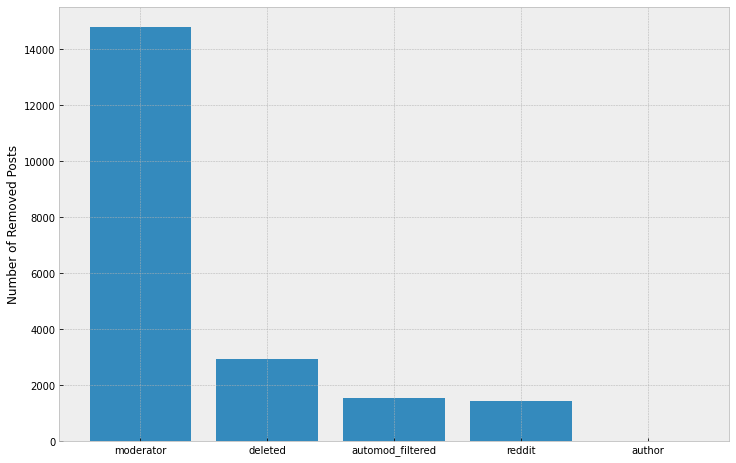

In [7]:
# 위 결과에 대한 시각화
removed_by = removed_posts_result['removed_by'].tolist()
number_of_removed_posts = removed_posts_result['number_of_removed_posts']

plt.figure(figsize=(12, 8))
plt.ylabel('Number of Removed Posts')
plt.bar(removed_by, number_of_removed_posts)
plt.show()

위 결과에 따르면, 대부분(약 71%)의 게시물들이 moderator에 의해 삭제되었음을 알 수 있다.



#### moderator에 의해 삭제된 게시물들에 대한 특징을 분석하기

In [8]:
title_removed_by_moderator = """
select title
from data
where removed_by = 'moderator'
"""

title_removed_by_moderator_result = ps.sqldf(title_removed_by_moderator, locals())
title_removed_by_moderator_result

,title
0,Wordcloud of trending videos on YouTube in the...
1,Immunization in India. Source: https://niti.go...
2,How to quickly estimate the impact of players ...
3,I follow a Twitter account that explores fake ...
4,Top 50 Highest Grossing Video Games Franchises...
...,...
14784,Land Surface Temperature of The Netherlands fo...
14785,The first 1000 digits of pi
14786,My aim improvement over time. Each different c...
14787,The beautiful downfall of the NBA. Long live H...


word cloud를 통한 게시물 title에 대한 시각화

(-0.5, 1599.5, 799.5, -0.5)

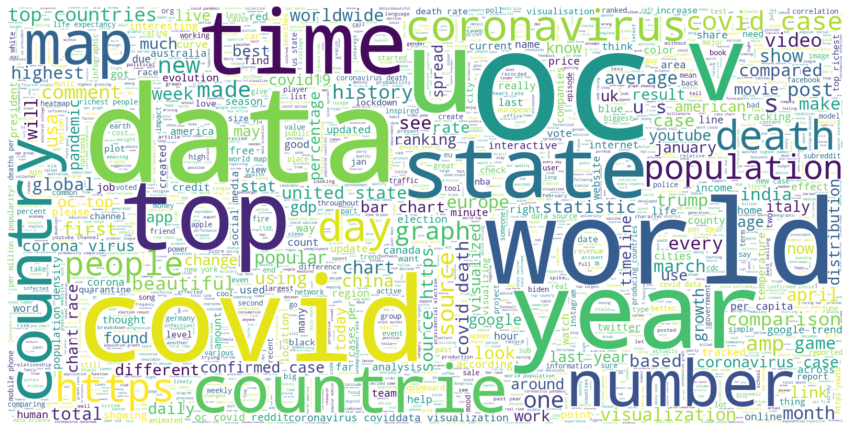

In [9]:
word_string = " ".join(title_removed_by_moderator_result['title'].str.lower())
plt.figure(figsize=(15,15))
word_cloud = WordCloud(background_color = "white", stopwords=STOPWORDS, max_words=2000,
                      max_font_size=300, width=1600, height=800)
word_cloud.generate(word_string)

plt.imshow(word_cloud.recolor(colormap='viridis', random_state=17), interpolation='bilinear')
plt.axis('off')

시각화를 통하여, 삭제된 게시물의 title에서 기존 레딧 생태계에서 볼 수 없는 "코로나"에 대한 단어들이 비정상적으로 많이 노출된 것을 확인할 수 있었다. 

"코로나" 관련 게시물들이 전체 삭제된 게시물에서 비중이 얼마나 되는지 알아보고자 한다.

In [10]:
covid_count_removed_by_moderator = """
select count(id) covid_count_removed_by_moderator
from data
where removed_by = 'moderator' and title like '%covid%' or 
                                   title like '%coronavirus%'
"""

covid_count_removed_by_moderator_result = ps.sqldf(covid_count_removed_by_moderator, locals())
covid_count_removed_by_moderator_result

,covid_count_removed_by_moderator
0,4109


위 결과에 따르면, moderator에 의해 삭제된 코로나 관련 게시물의 비중은 전체에서 약 28%를 차지하는 것을 알 수가 있다.

이어서, 삭제된 게시물 중 "코로나" 관련 게시물들에 대한 특징을 분석하고자 한다.

In [11]:
covid_removed_by_moderator = """
select title
from data
where removed_by = 'moderator' and title like '%covid%' or 
                                   title like '%coronavirus%'
"""

covid_removed_by_moderator_result = ps.sqldf(covid_removed_by_moderator, locals())
covid_removed_by_moderator_result

,title
0,Can anyone guess the date I received a positiv...
1,Top 15 Covid19 Vaccinated Countries | Timelaps...
2,[OC] UK coronavirus cases by date and age
3,Weight gained from start of lockdown up until ...
4,[OC] Are countries with high percentage of cov...
...,...
4104,[OC] How the SARS Coronavirus Spread around th...
4105,Wuhan Coronavirus &amp; SARS: Side-by-Side GC ...
4106,A map that tracks cases and deaths from the Co...
4107,Wuhan Coronavirus Visualization Map (2019-nCoV...


word cloud를 통한 코로나 관련 게시물 title에 대한 시각화

(-0.5, 1599.5, 799.5, -0.5)

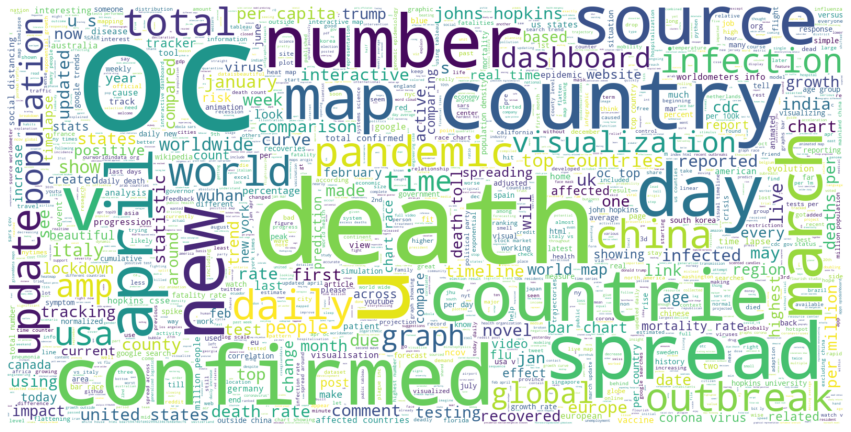

In [12]:
word_string_covid = " ".join(covid_removed_by_moderator_result['title'].str.lower())
stop_words = ['covid', 'coronavirus', 'covid19', 'case', 'state', 'data', 'https', 'cases'] + list(STOPWORDS)
plt.figure(figsize=(15,15))
word_cloud = WordCloud(background_color = "white", stopwords=stop_words, max_words=2000,
                      max_font_size=300, width=1600, height=800)
word_cloud.generate(word_string_covid)

plt.imshow(word_cloud.recolor(colormap='viridis', random_state=17), interpolation='bilinear')
plt.axis('off')

시각화를 통하여, 죽음, 확산, 확진, 감염과 같은 부정적인 단어들이 두드러지게 나타나는 것을 확인할 수 있다.

다음으로는 코로나가 아닌, 외설적이고 폭력적인 단어들이 포함된 게시물들이 차지하는 비중이 얼마나 있는지 분석하고자 한다.

In [13]:
violence_count_removed_by_moderator = """
select count(id) violence_count_removed_by_moderator
from data
where removed_by = 'moderator' and title like '%fuck%' or 
                                   title like '%suck%' or 
                                   title like '%sex%' or 
                                   title like '%asshole%' or 
                                   title like '%ass%' or 
                                   title like '%bitch%' or 
                                   title like '%porn%' or 
                                   title like '%NSFW%' or 
                                   title like '%orgasm%'
"""

violence_count_removed_by_moderator_result = ps.sqldf(violence_count_removed_by_moderator, locals())
violence_count_removed_by_moderator_result

,violence_count_removed_by_moderator
0,6018


위 결과에 따르면, moderator에 의해 삭제된 외설적이거나 폭력적인 단어가 내포된 게시물의 비중은 전체에서 약 절반이상을 차지하는 것을 알 수가 있다.

## Results
- 평소보다 게시물의 삭제건이 비정상적으로 급증한 이유는 코로나 바이러스 감염과 확산이 일어남에 따라 코로나 관련 게시물들이 증가하였기 때문이다.
- Moderator분들께서 외설적이거나 폭력적인 게시물에 대한 삭제는 지속적으로 잘 이루어지고 있으며, 코로나 게시물에 대한 Moderator분들의 스트레스를 완화해 줄 필요가 있다.
- Moderator분들의 스트레스를 완화해 줄 수 있는 방안으로는 코로나 관련된 신규 카테고리를 생성하여 게시물들을 모으는 방안이 있을 것으로 생각된다.
